In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplpub
mplpub.setup(template='acs')

In [9]:
n1_z_disp = pd.read_csv('data/RP_n1_Asite_z_displacements.csv')
n2_z_disp = pd.read_csv('data/RP_n2_Asite_z_displacements.csv')
n3_z_disp = pd.read_csv('data/RP_n3_Asite_z_displacements.csv')
n4_z_disp = pd.read_csv('data/RP_n4_Asite_z_displacements.csv')
n5_z_disp = pd.read_csv('data/RP_n5_Asite_z_displacements.csv')
n6_z_disp = pd.read_csv('data/RP_n6_Asite_z_displacements.csv')

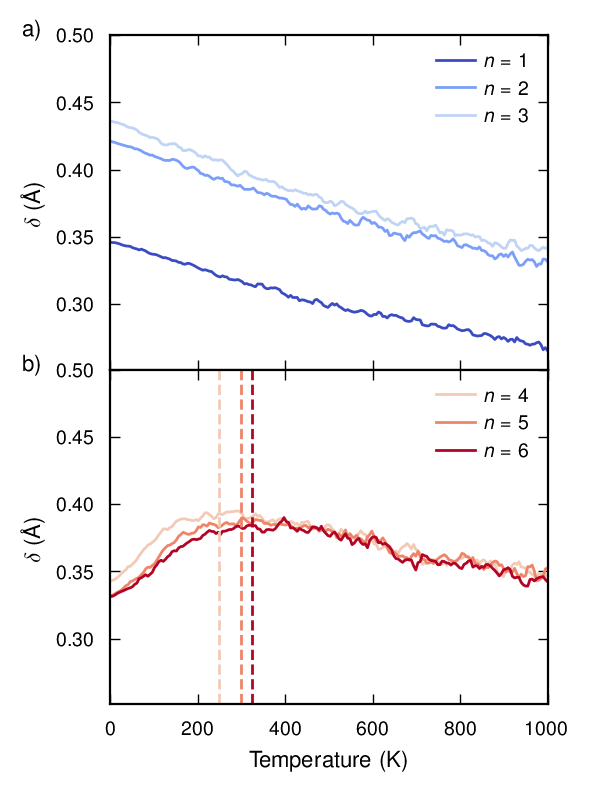

In [10]:
colors = plt.cm.coolwarm(np.linspace(0,1,6))
fig, ax = plt.subplots(2,1, figsize=(3,4), dpi=200)
ax[0].plot(n1_z_disp.temp, n1_z_disp.z_diff_layer0, color= colors[0], label = r'$n=1$')
ax[0].plot(n2_z_disp.temp, n2_z_disp.z_diff_layer0, color= colors[1], label = r'$n=2$')
ax[0].plot(n3_z_disp.temp, n3_z_disp.z_diff_layer0, color= colors[2], label = r'$n=3$')
ax[1].plot(n4_z_disp.temp, n4_z_disp.z_diff_layer0, color= colors[3], label = r'$n=4$')
ax[1].plot(n5_z_disp.temp, n5_z_disp.z_diff_layer0, color= colors[4], label = r'$n=5$')
ax[1].plot(n6_z_disp.temp, n6_z_disp.z_diff_layer0, color= colors[5], label = r'$n=6$')
ax[0].set_ylim([0.251,0.5])
ax[1].set_ylim([0.251,0.5])
ax[0].set_xticklabels([])
ax[0].text(-0.2,1, 'a)', transform = ax[0].transAxes)
ax[1].text(-0.2,1, 'b)', transform = ax[1].transAxes)
ax[1].vlines(250,-0.5,0.5, color = colors[3] , linestyle = 'dashed')
ax[1].vlines(300,-0.5,0.5, color = colors[4] , linestyle = 'dashed')
ax[1].vlines(325,-0.5,0.5, color = colors[5] , linestyle = 'dashed')
ax[0].legend()
ax[1].legend()
ax[0].set_xlim([0,1000])
ax[1].set_xlim([0,1000])
ax[0].set_ylabel(r'$\delta$ (\AA)')
ax[1].set_ylabel(r'$\delta$ (\AA)')
ax[0].set_xlabel('Temperature (K)') 
ax[1].set_xlabel('Temperature (K)') 
fig.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('rumpling.png')

Number of layers 14


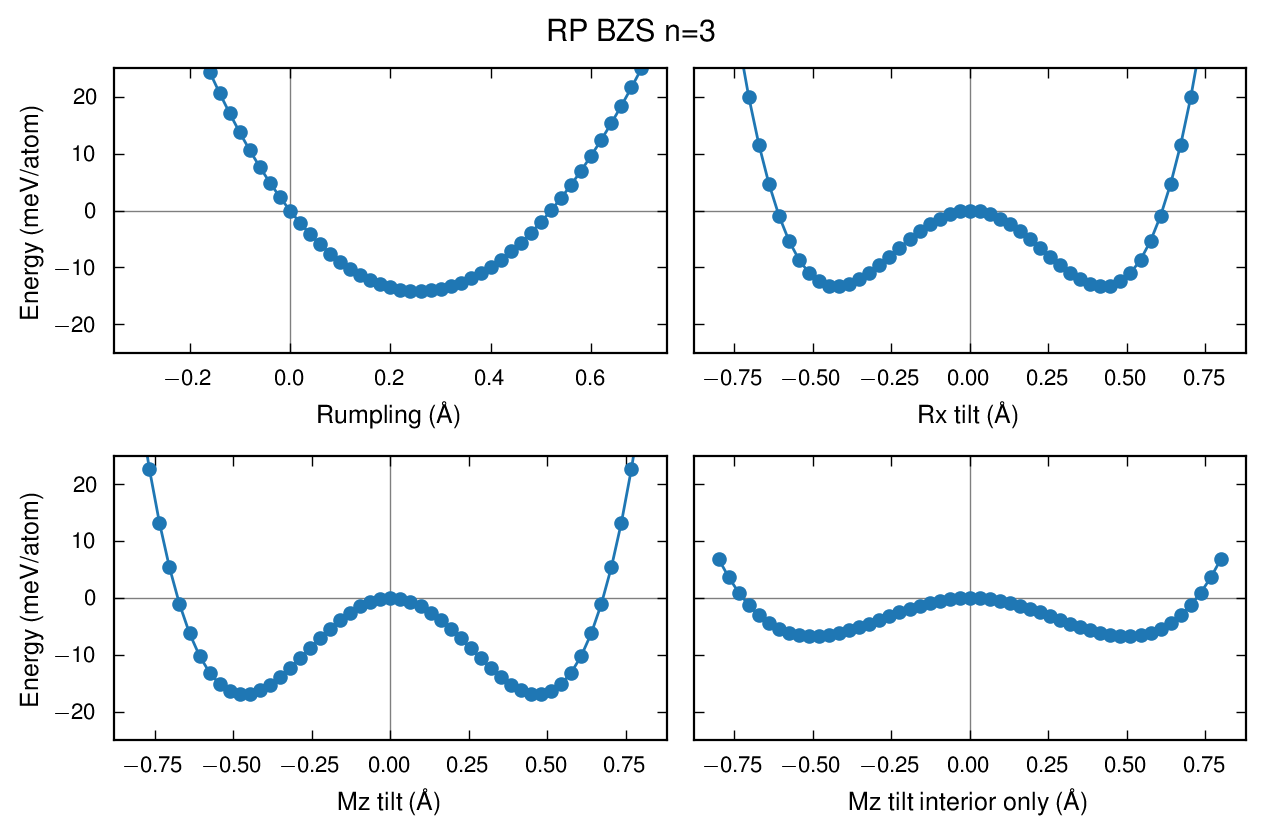

amp rump 0.0
amp rump 0.2
amp rump 0.4
amp rump 0.6
amp rump 0.8
amp rump 1.0


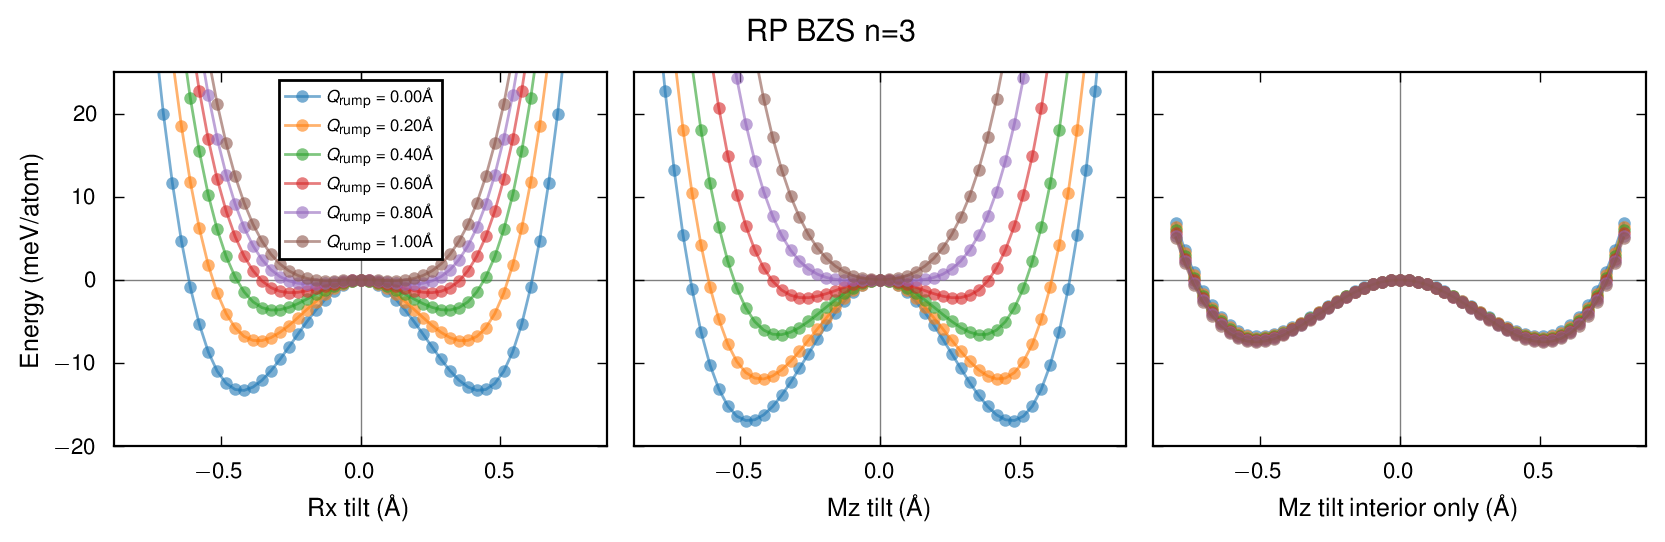

amp tilt x 0.0
amp tilt x 0.2
amp tilt x 0.4
amp tilt x 0.6
amp tilt x 0.8
amp tilt x 1.0


KeyError: 0.25

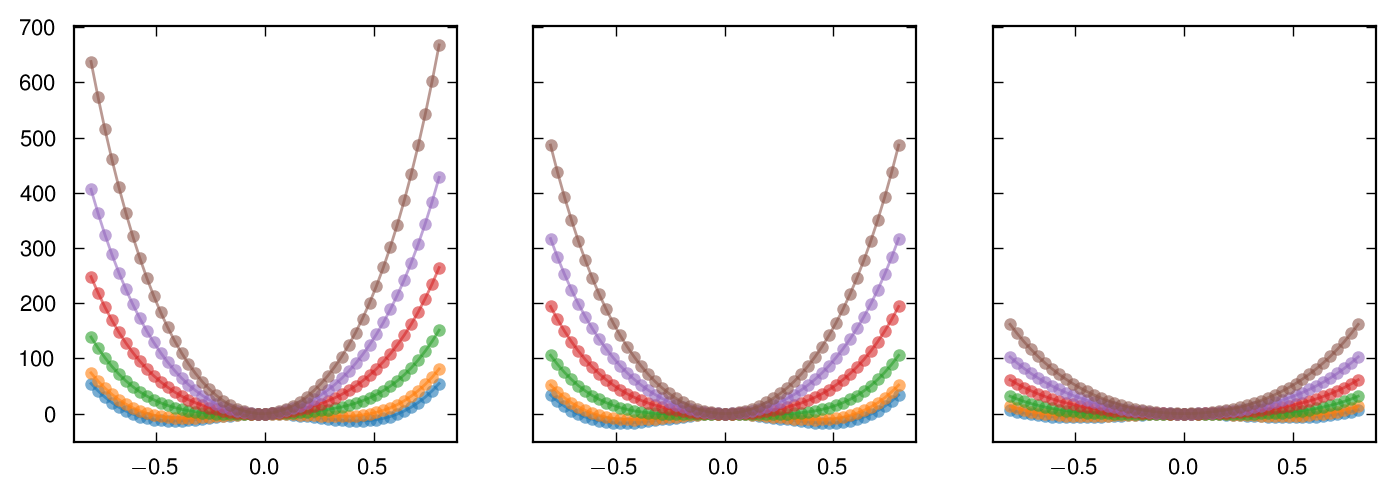

In [16]:
import numpy as np
from ase.io import read, write
from ase.visualize import view
from calorine.calculators import CPUNEP
from calorine.tools import relax_structure
from ase.constraints import FixAtoms
import pandas as pd
import matplotlib.pyplot as plt
import mplpub
mplpub.setup()


def group_atoms_by_z(atoms, tolerance=0.1):
    """
    Groups atoms in an Atoms object based on their z-positions.

    Parameters:
    - atoms: ASE Atoms object
    - tolerance: Maximum difference in z to be considered in the same group

    Returns:
    - A list of lists, each sublist contains indices of atoms in the same z-layer
    """
    # Get all z-coordinates with indices
    positions = atoms.get_positions()
    z_with_indices = [(i, pos[2]) for i, pos in enumerate(positions)]

    # Sort by z
    z_with_indices.sort(key=lambda x: x[1])

    # Group by tolerance
    groups = []
    current_group = [z_with_indices[0][0]]
    current_z = z_with_indices[0][1]

    for idx, z in z_with_indices[1:]:
        if abs(z - current_z) <= tolerance:
            current_group.append(idx)
        else:
            groups.append(current_group)
            current_group = [idx]
            current_z = z
    groups.append(current_group)  # Add last group

    return groups


def apply_rumpling(atoms, amp_rump):

    Ba_inds_bottom = [i for i in layer_indices[0]+layer_indices[n_layers_per_slab] if atoms_ideal[i].symbol == 'Ba']
    Ba_inds_top = [i for i in layer_indices[n_layers_per_slab-1]+layer_indices[2*n_layers_per_slab-1] if atoms_ideal[i].symbol == 'Ba']
    
    S_inds_bottom = [i for i in layer_indices[0]+layer_indices[n_layers_per_slab] if atoms_ideal[i].symbol == 'S']
    S_inds_top = [i for i in layer_indices[n_layers_per_slab-1]+layer_indices[2*n_layers_per_slab-1] if atoms_ideal[i].symbol == 'S']

    atoms.positions[Ba_inds_bottom, 2] += amp_rump / 2
    atoms.positions[S_inds_bottom, 2] -= amp_rump / 2
    atoms.positions[Ba_inds_top, 2] -= amp_rump / 2
    atoms.positions[S_inds_top, 2] += amp_rump / 2


def apply_mode_interior(atoms, amp_tilt, mode_name):
    atoms.positions[interior_indices] += amp_tilt * atoms.get_array(mode_name)[interior_indices]


def apply_mode(atoms, amp_tilt, mode_name):
    atoms.positions += amp_tilt * atoms.get_array(mode_name)


# parameters
n = 3
alat = 5.0

# setup
atoms_ideal = read(f'/Users/prakriti/2025_RP_phases_2/extxyz/RP_3_000_000.extxyz')
model_path = 'model/nep.txt'
calc = CPUNEP(model_path)


# group atoms by layer 
n_layers_per_slab = n * 2 + 1
layer_indices = group_atoms_by_z(atoms_ideal)
print('Number of layers', len(layer_indices))
assert n_layers_per_slab * 2 == len(layer_indices)


# sanity check
if False:
    for it, indices in enumerate(layer_indices):
        atoms_ideal.numbers[indices] = it + 4 

# find interior layers (for tilting), i.e. exclude two atomic layers from each surface
layer_inds_to_exclude = [0, 1, n_layers_per_slab - 2, n_layers_per_slab - 1,
                         n_layers_per_slab, n_layers_per_slab + 1, 2 * n_layers_per_slab - 2, 2 * n_layers_per_slab - 1]

interior_indices = []
for it, indices in enumerate(layer_indices):
    if it in layer_inds_to_exclude:
        continue
    interior_indices.extend(indices)


# relax only cell
atoms = atoms_ideal.copy()
c = FixAtoms(np.arange(0, len(atoms)))
atoms.set_constraint(c)
atoms.calc = calc
relax_structure(atoms)
E_ref = atoms.get_potential_energy() / len(atoms)


# rumpling 1D landscape
amp_rump_vals = np.linspace(-0.3, 0.7, 51)
records = []
for amp_rump in amp_rump_vals:

    atoms2 = atoms.copy()
    atoms2.calc = calc
    apply_rumpling(atoms2, amp_rump)

    row = dict(amp_rump = amp_rump, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
    records.append(row)
df1 = pd.DataFrame(records)


# tilting X 1D landscape
amp_tilt_vals = np.linspace(-0.8, 0.8, 51)
records = []
for amp_tilt in amp_tilt_vals:

    atoms2 = atoms.copy()
    atoms2.calc = calc
    apply_mode(atoms2, amp_tilt, 'Rx1')
    apply_mode(atoms2, amp_tilt, 'Rx2')

    row = dict(amp_tilt=amp_tilt, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
    records.append(row)
df2 = pd.DataFrame(records)

# tilting Z 1D landscape
records = []
for amp_tilt in amp_tilt_vals:

    atoms2 = atoms.copy()
    atoms2.calc = calc
    apply_mode(atoms2, amp_tilt, 'Mz1')
    apply_mode(atoms2, amp_tilt, 'Mz2')

    row = dict(amp_tilt=amp_tilt, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
    records.append(row)
df3 = pd.DataFrame(records)


# tilting Z only interior 1D landscape
records = []
for amp_tilt in amp_tilt_vals:

    atoms2 = atoms.copy()
    atoms2.calc = calc
    apply_mode_interior(atoms2, amp_tilt, 'Mz1')
    apply_mode_interior(atoms2, amp_tilt, 'Mz2')

    row = dict(amp_tilt=amp_tilt, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
    records.append(row)
df4 = pd.DataFrame(records)


fig, axes = plt.subplots(2, 2, figsize=(6.4, 4.2), dpi=200, sharey=True)
ax1, ax2, ax3, ax4 = axes.flat
ylim = [-25, 25]

ax1.plot(df1.amp_rump, 1000 * df1.E, '-o')
ax1.set_xlabel('Rumpling (Å)')
ax1.set_ylabel('Energy (meV/atom)')

ax2.plot(df2.amp_tilt, 1000 * df2.E, '-o')
ax2.set_xlabel('Rx tilt (Å)')

ax3.plot(df3.amp_tilt, 1000 * df3.E, '-o')
ax3.set_xlabel('Mz tilt (Å)')
ax3.set_ylabel('Energy (meV/atom)')

ax4.plot(df4.amp_tilt, 1000 * df4.E, '-o')
ax4.set_xlabel('Mz tilt interior only (Å)')

for ax in axes.flat:
    ax.axhline(y=0, lw=0.5, alpha=0.5, color='k', zorder=-100)
    ax.axvline(x=0, lw=0.5, alpha=0.5, color='k', zorder=-100)
    ax.set_ylim(ylim)

fig.suptitle(f'RP BZS n={n}')
fig.align_ylabels()
fig.tight_layout(rect=[0, 0, 1, 1.02])
plt.show(block=True)





# 1D tilting landscape with rumpling activated
# -----------------------------------------------

amp_rump_vals = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

dfs2 = dict()
dfs3 = dict()
dfs4 = dict()
for amp_rump in amp_rump_vals:
    print('amp rump', amp_rump)

    # Rx
    records = []
    for amp_tilt in amp_tilt_vals:

        atoms2 = atoms.copy()
        atoms2.calc = calc
        apply_rumpling(atoms2, amp_rump)
        apply_mode(atoms2, amp_tilt, 'Rx1')
        apply_mode(atoms2, amp_tilt, 'Rx2')

        row = dict(amp_tilt=amp_tilt, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
        records.append(row)
    dfs2[amp_rump] = pd.DataFrame(records)
    
    # Mz
    records = []
    for amp_tilt in amp_tilt_vals:

        atoms2 = atoms.copy()
        atoms2.calc = calc
        apply_rumpling(atoms2, amp_rump)
        apply_mode(atoms2, amp_tilt, 'Mz1')
        apply_mode(atoms2, amp_tilt, 'Mz2')

        row = dict(amp_tilt=amp_tilt, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
        records.append(row)
    dfs3[amp_rump] = pd.DataFrame(records)
    
    # Mz interior
    records = []
    for amp_tilt in amp_tilt_vals:

        atoms2 = atoms.copy()
        atoms2.calc = calc
        apply_rumpling(atoms2, amp_rump)
        apply_mode_interior(atoms2, amp_tilt, 'Mz1')
        apply_mode_interior(atoms2, amp_tilt, 'Mz2')

        row = dict(amp_tilt=amp_tilt, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
        records.append(row)
    dfs4[amp_rump] = pd.DataFrame(records)


fig, axes = plt.subplots(1, 3, figsize=(8.4, 2.7), dpi=200, sharey=True)
ax1, ax2, ax3 = axes.flat
ylim = [-20, 25]

plot_kwargs = dict(mec='none', alpha=0.6)

for amp_rump in amp_rump_vals:
    df2 = dfs2[amp_rump]
    E_tmp = df2.loc[df2.amp_tilt == 0].E.values[0]
    ax1.plot(df2.amp_tilt, 1000 * (df2.E-E_tmp), '-o', label=r'$Q_{\text{rump}}$' + f' = {amp_rump:.2f}Å', **plot_kwargs)

    df3 = dfs3[amp_rump]
    E_tmp = df3.loc[df3.amp_tilt == 0].E.values[0]
    ax2.plot(df3.amp_tilt, 1000 * (df3.E-E_tmp), '-o', **plot_kwargs)
    
    df4 = dfs4[amp_rump]
    E_tmp = df4.loc[df4.amp_tilt == 0].E.values[0]
    ax3.plot(df4.amp_tilt, 1000 * (df4.E-E_tmp), '-o', **plot_kwargs)

ax1.legend(loc=9, fontsize=6, frameon=True)
ax1.set_ylabel('Energy (meV/atom)')
ax1.set_xlabel('Rx tilt (Å)')
ax2.set_xlabel('Mz tilt (Å)')
ax3.set_xlabel('Mz tilt interior only (Å)')

for ax in axes.flat:
    ax.axhline(y=0, lw=0.5, alpha=0.5, color='k', zorder=-100)
    ax.axvline(x=0, lw=0.5, alpha=0.5, color='k', zorder=-100)
    ax.set_ylim(ylim)

fig.suptitle(f'RP BZS n={n}')
fig.align_ylabels()
fig.tight_layout(rect=[0, 0, 1, 1.05])
plt.show(block=True)




## Tilting in Y/Z when X tilt activated
# -------------------------------------
amp_tilt_vals2 = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 0.25, 0.75, 0.5]

dfs33 = dict()
dfs44 = dict()
dfs55 = dict()
for amp_tilt2 in amp_rump_vals:
    print('amp tilt x', amp_tilt2)

    # Mz
    records = []
    for amp_tilt in amp_tilt_vals:

        atoms2 = atoms.copy()
        atoms2.calc = calc
        apply_mode(atoms2, amp_tilt2, 'Rx1')
        apply_mode(atoms2, amp_tilt2, 'Rx2')
        apply_mode(atoms2, amp_tilt, 'Mz1')
        apply_mode(atoms2, amp_tilt, 'Mz2')

        row = dict(amp_tilt=amp_tilt, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
        records.append(row)
    dfs33[amp_tilt2] = pd.DataFrame(records)
    
    # Mz interior
    records = []
    for amp_tilt in amp_tilt_vals:

        atoms2 = atoms.copy()
        atoms2.calc = calc
        apply_mode(atoms2, amp_tilt2, 'Rx1')
        apply_mode(atoms2, amp_tilt2, 'Rx2')
        apply_mode_interior(atoms2, amp_tilt, 'Mz1')
        apply_mode_interior(atoms2, amp_tilt, 'Mz2')

        row = dict(amp_tilt=amp_tilt, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
        records.append(row)
    dfs44[amp_tilt2] = pd.DataFrame(records)


    # Ry
    records = []
    for amp_tilt in amp_tilt_vals:

        atoms2 = atoms.copy()
        atoms2.calc = calc
        apply_mode(atoms2, amp_tilt2, 'Rx1')
        apply_mode(atoms2, amp_tilt2, 'Rx2')
        apply_mode(atoms2, amp_tilt, 'Ry1')
        apply_mode(atoms2, amp_tilt, 'Ry2')

        row = dict(amp_tilt=amp_tilt, E=atoms2.get_potential_energy()/len(atoms) - E_ref)
        records.append(row)
    dfs55[amp_tilt2] = pd.DataFrame(records)


fig, axes = plt.subplots(1, 3, figsize=(8.4, 2.7), dpi=200, sharey=True)
ax1, ax2, ax3 = axes.flat
ylim = [-20, 25]

plot_kwargs = dict(mec='none', alpha=0.6)

for amp_tilt2 in amp_tilt_vals2:
    df3 = dfs33[amp_tilt2]
    E_tmp = df3.loc[df3.amp_tilt == 0].E.values[0]
    ax2.plot(df3.amp_tilt, 1000 * (df3.E-E_tmp), '-o', label=r'$Q_{\text{Rx}}$' + f' = {amp_tilt2:.2f}Å', **plot_kwargs)
    
    df4 = dfs44[amp_tilt2]
    E_tmp = df4.loc[df4.amp_tilt == 0].E.values[0]
    ax3.plot(df4.amp_tilt, 1000 * (df4.E-E_tmp), '-o', **plot_kwargs)

    df5 = dfs55[amp_tilt2]
    E_tmp = df5.loc[df5.amp_tilt == 0].E.values[0]
    ax1.plot(df5.amp_tilt, 1000 * (df5.E-E_tmp), '-o', label=r'$Q_{\text{Rx}}$' + f' = {amp_tilt2:.2f}Å', **plot_kwargs)

ax1.legend(loc=9, fontsize=6, frameon=True)
ax1.set_ylabel('Energy (meV/atom)')

ax1.set_xlabel('Ry tilt (Å)')
ax2.set_xlabel('Mz tilt (Å)')
ax3.set_xlabel('Mz tilt interior only (Å)')

for ax in axes.flat:
    ax.axhline(y=0, lw=0.5, alpha=0.5, color='k', zorder=-100)
    ax.axvline(x=0, lw=0.5, alpha=0.5, color='k', zorder=-100)
    ax.set_ylim(ylim)

fig.suptitle(f'RP BZS n={n}')
fig.align_ylabels()
fig.tight_layout(rect=[0, 0, 1, 1.05])
plt.show(block=True)




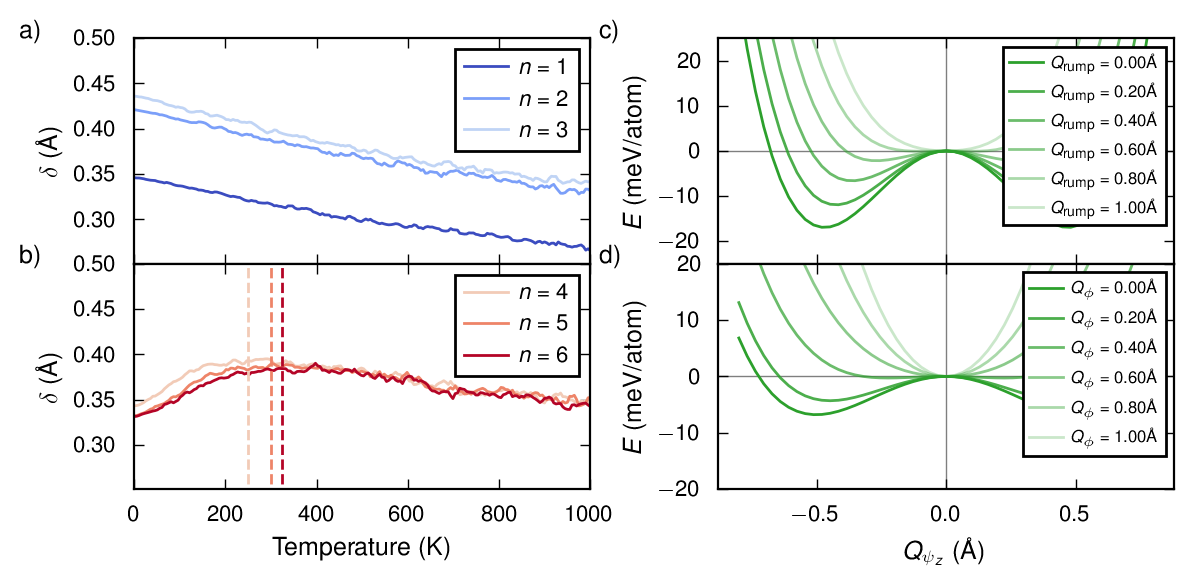

In [23]:
colors = plt.cm.coolwarm(np.linspace(0,1,6))
fig, ax = plt.subplots(2,2, figsize=(6,3), dpi=200)
ax[0,0].plot(n1_z_disp.temp, n1_z_disp.z_diff_layer0, color= colors[0], label = r'$n=1$')
ax[0,0].plot(n2_z_disp.temp, n2_z_disp.z_diff_layer0, color= colors[1], label = r'$n=2$')
ax[0,0].plot(n3_z_disp.temp, n3_z_disp.z_diff_layer0, color= colors[2], label = r'$n=3$')
ax[1,0].plot(n4_z_disp.temp, n4_z_disp.z_diff_layer0, color= colors[3], label = r'$n=4$')
ax[1,0].plot(n5_z_disp.temp, n5_z_disp.z_diff_layer0, color= colors[4], label = r'$n=5$')
ax[1,0].plot(n6_z_disp.temp, n6_z_disp.z_diff_layer0, color= colors[5], label = r'$n=6$')
ax[0,0].set_ylim([0.251,0.5])
ax[1,0].set_ylim([0.251,0.5])
ax[0,0].set_xticklabels([])
ax[0,0].text(-0.25,1, 'a)', transform = ax[0,0].transAxes)
ax[1,0].text(-0.25,1, 'b)', transform = ax[1,0].transAxes)
ax[0,1].text(-0.26,1, 'c)', transform = ax[0,1].transAxes)
ax[1,1].text(-0.26,1, 'd)', transform = ax[1,1].transAxes)
ax[1,0].vlines(250,-0.5,0.5, color = colors[3] , linestyle = 'dashed')
ax[1,0].vlines(300,-0.5,0.5, color = colors[4] , linestyle = 'dashed')
ax[1,0].vlines(325,-0.5,0.5, color = colors[5] , linestyle = 'dashed')
ax[0,0].legend(frameon=True)
ax[1,0].legend(frameon=True)
ax[0,0].set_xlim([0,1000])
ax[1,0].set_xlim([0,1000])
ax[0,0].set_ylabel(r'$\delta$ (\AA)')
ax[1,0].set_ylabel(r'$\delta$ (\AA)')
ax[0,0].set_xlabel('Temperature (K)') 
ax[1,0].set_xlabel('Temperature (K)') 

alpha = 1
for amp_rump in amp_rump_vals:
    df3 = dfs3[amp_rump]
    E_tmp = df3.loc[df3.amp_tilt == 0].E.values[0]
    ax[0,1].plot(df3.amp_tilt, 1000 * (df3.E-E_tmp), '-',label=r'$Q_{\text{rump}}$' + f' = {amp_rump:.2f}Å', color = 'tab:green', alpha=alpha)
    alpha = alpha - 0.15
ax[0,1].set_ylim([-25,25])

alpha  = 1

amp_tilt_vals2 = [0.0, 0.2,0.4,0.6,0.8,1.0]
for amp_tilt2 in amp_tilt_vals2:
    df3 = dfs33[amp_tilt2]
    E_tmp = df3.loc[df3.amp_tilt == 0].E.values[0]
    #ax[1,1].plot(df3.amp_tilt, 1000 * (df3.E-E_tmp), '-', label=r'$Q_{\text{Rx}}$' + f' = {amp_tilt2:.2f}Å', color= 'tab:pink', alpha = alpha)

    df4 = dfs44[amp_tilt2]
    E_tmp = df4.loc[df4.amp_tilt == 0].E.values[0]
    ax[1,1].plot(df4.amp_tilt, 1000 * (df4.E-E_tmp), '-', label=r'$Q_{\phi}$' + f' = {amp_tilt2:.2f}Å', color = 'tab:green', alpha = alpha)
    alpha = alpha - 0.15

ax[1,1].set_ylim([-20,20])

ax[0,1].legend(frameon=True, fontsize = 6, loc = 'upper right')
ax[0,1].set_ylabel(r'$E$ (meV/atom)')
ax[1,1].legend(frameon=True, fontsize = 6, loc = 'upper right')
ax[1,1].set_ylabel(r'$E$ (meV/atom)')
#
ax[0,1].axhline(y=0, lw=0.5, alpha=0.5, color='k', zorder=-100)
ax[0,1].axvline(x=0, lw=0.5, alpha=0.5, color='k', zorder=-100)
ax[1,1].axhline(y=0, lw=0.5, alpha=0.5, color='k', zorder=-100)
ax[1,1].axvline(x=0, lw=0.5, alpha=0.5, color='k', zorder=-100)

#ax[0,1].text(0.43,0.1, r'$M_z$ tilt', transform = ax[0,1].transAxes, bbox = dict(edgecolor = 'k', facecolor ='white'))
#ax[1,1].text(0.43,0.1, r'$M_z$ tilt', transform = ax[1,1].transAxes, bbox = dict(edgecolor = 'k', facecolor ='white'))
ax[0,1].set_xlabel(r'$Q$ (Å)') 
ax[1,1].set_xlabel(r'$Q_{\psi_\text{z}}$ (Å)') 

fig.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0.28)
plt.savefig('figs/rumpling.png')